# What is behind the auto-kerchunk.

auto-kerhcunk is developped in 2021, following [this blogpost](https://medium.com/pangeo/fake-it-until-you-make-it-reading-goes-netcdf4-data-on-aws-s3-as-zarr-for-rapid-data-access-61e33f8fe685) example of applying kerchunk to data stored in s3, by adapting it to HPC enviroment and automatise the creation of kerchunk catalogue of many data sets exisiging on in HPC datalake.   

This notebook explains what is behind the auto-kerchunk, by manually proceed creation of kerchunk catalogue.   

Please reffer what is kerchunk (and what is zarr, what is 'chunk') to [this ducmentation ]( 
https://pangeo-data.github.io/clivar-2022/pangeo101/chunking_introduction.html)


## In this example, we will use croco data output. 

In [8]:
import glob
dirdata = '/home/datawork-lops-siam-moawi/PROJECTS/NATL_COUPLED/gcambon/CONFIGS/ARVOR/rundir/ARVOR_V2_exp1_Ofrc_outputs/'
lref=sorted(glob.glob(dirdata + "*/*avg_*"))

In [29]:
import glob
#dir_url = 'https://data-dataref.ifremer.fr/marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/'
#file_pattern = 'MARC_F1-MARS3D-SEINE_*Z.nc'
dir_url = '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/'
file_pattern = 'MARC_F1-MARS3D-SEINE_20150101T2*Z.nc'
file_paths = glob.glob(dir_url+file_pattern)
file_paths

['/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T2000Z.nc',
 '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T2300Z.nc',
 '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T2200Z.nc',
 '/home/ref-marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2015/MARC_F1-MARS3D-SEINE_20150101T2100Z.nc']

## Starting dask cluster on HPC
Please reffer dask-hpcconfig datarmor [example jupyter notebook](https://github.com/umr-lops/dask-hpcconfig/tree/main/docs/tutorials) what next two cell means.
  

In [30]:
import dask_hpcconfig
from distributed import Client

In [11]:

overrides = {
}  # ,"cluster.c": n_worker_per_node }

cluster = dask_hpcconfig.cluster("datarmor-local", **overrides)
client = Client(cluster)
client


/home/datawork-lops-iaocea/conda-env/pangeo-fish_0323/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45435 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/todaka/proxy/45435/status,
Dashboard: /user/todaka/proxy/45435/status,Workers: 14
Total threads: 28,Total memory: 115.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43244,Workers: 14
Dashboard: /user/todaka/proxy/45435/status,Total threads: 28
Started: Just now,Total memory: 115.00 GiB
Comm: tcp://127.0.0.1:49683,Total threads: 2
Dashboard: /user/todaka/proxy/57072/status,Memory: 8.21 GiB
Nanny: tcp://127.0.0.1:52708,


In [31]:
import dask.bag as db
import fsspec
import kerchunk.hdf

def translate_dask(file):
    url = 'file://' + file
    print('working on ', file)
    with fsspec.open(url) as inf:
        h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, url, inline_threshold=100)
        return h5chunks.translate() 

b = db.from_sequence(lref[0:4])
result_indask = b.map(translate_dask)
result_indask

dask.bag<translate_dask, npartitions=4>

In [32]:
%%time
result=result_indask.compute()

CPU times: user 2.99 s, sys: 532 ms, total: 3.52 s
Wall time: 20.2 s


In [33]:
%%time
from kerchunk.combine import MultiZarrToZarr
mzz = MultiZarrToZarr(
    result,
    concat_dims=["time"],
)
out = mzz.translate()

CPU times: user 912 ms, sys: 332 ms, total: 1.24 s
Wall time: 974 ms


## Following procedure use also dask for above 'combine' 

In [34]:
%%time
from kerchunk.combine import auto_dask, JustLoad
d = auto_dask(
    result,
    single_driver=JustLoad,
    single_kwargs={} ,#"storage_options": {"anon": False}},
    mzz_kwargs={"concat_dims": ["time"]},
    n_batches=3,   
)

2023-03-17 15:38:42,767 - distributed.worker - WARNING - Compute Failed
Key:       lambda-d17c20f0-8c9c-4533-8bca-ce25c025eab1
Function:  execute_task
args:      ((<function auto_dask.<locals>.<lambda> at 0x2aaab3834f70>, (<class 'dict'>, [['version', 1], ['refs', (<class 'dict'>, [['.zgroup', '{"zarr_format":2}'], ['.zattrs', '{"CPP-options":"REGIONAL ARVOR_exp1_Ofrc MPI OBC_NORTH OBC_SOUTH LOGFILE NC4PAR CURVGRID SPHERICAL MASKING NEW_S_COORD SOLVE3D UV_COR UV_ADV SALINITY NONLIN_EOS BULK_FLUX BULK_GUSTINESS BULK_LW ONLINE ERA_ECMWF SFLUX_CFB SEA_ICE_NOFLUX FRC_BRY Z_FRC_BRY M2_FRC_BRY M3_FRC_BRY T_FRC_BRY UV_HADV_UP3 UV_VADV_SPLINES TS_HADV_RSUP3 TS_DIF4 TS_VADV_SPLINES SPONGE VADV_ADAPT_IMP LIMIT_BSTRESS LMD_MIXING LMD_SKPP LMD_BKPP LMD_RIMIX LMD_CONVEC LMD_NONLOCAL ANA_BSFLUX ANA_BTFLUX OBC_M2CHARACT OBC_M3ORLANSKI OBC_TORLANSKI AVERAGES AVERAGES_K EXACT_RESTART TS_HADV_C4 M2FILTER_POWER TRACERS TEMPERATURE HZR VAR_RHO_2D SPLIT_EOS UV_MIX_S DIF_COEF_3D TS_MIX_ISO TS_MIX_IMP TS_MIX

AttributeError: 'dict' object has no attribute 'startswith'

In [14]:
import xarray as xr

In [15]:
%%time
LTS = xr.open_dataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": out,
        },
        "consolidated": False
    },chunks={}
)
LTS

CPU times: user 9.29 s, sys: 1.36 s, total: 10.7 s
Wall time: 13 s


<xarray.Dataset>
Dimensions:     (time: 731, s_w: 76, eta_rho: 677, xi_rho: 1259, s_rho: 75,
                 auxil: 4, eta_v: 676, xi_u: 1258)
Coordinates: (12/14)
  * auxil       (auxil) float32 nan nan nan nan
  * eta_rho     (eta_rho) float32 1.0 2.0 3.0 4.0 ... 674.0 675.0 676.0 677.0
  * eta_v       (eta_v) float32 1.5 2.5 3.5 4.5 5.5 ... 673.5 674.5 675.5 676.5
    lat_rho     (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 677, 1259), meta=np.ndarray>
    lat_u       (time, eta_rho, xi_u) float32 dask.array<chunksize=(1, 677, 1258), meta=np.ndarray>
    lat_v       (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 676, 1259), meta=np.ndarray>
    ...          ...
    lon_v       (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 676, 1259), meta=np.ndarray>
  * s_rho       (s_rho) float32 -0.9933 -0.98 -0.9667 ... -0.02 -0.006667
  * s_w         (s_w) float32 -1.0 -0.9867 -0.9733 ... -0.02667 -0.01333 0.0
  * time        (time) float64 7.574e+08 7.575e+08 ... 8.204e+08 8.205e+08
  * xi_rho      (xi_rho) float32 1.0 2.0 3.0 ... 1.257e+03 1.258e+03 1.259e+03
  * xi_u        (xi_u) float32 1.5 2.5 3.5 4.5 ... 1.256e+03 1.258e+03 1.258e+03
Data variables: (12/39)
    AKt         (time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 16, 170, 315), meta=np.ndarray>
    Cs_r        (time, s_rho) float32 dask.array<chunksize=(1, 75), meta=np.ndarray>
    Cs_w        (time, s_w) float32 dask.array<chunksize=(1, 76), meta=np.ndarray>
    Vtransform  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    angle       (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 677, 1259), meta=np.ndarray>
    bostr       (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 677, 1259), meta=np.ndarray>
    ...          ...
    v           (time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 15, 169, 315), meta=np.ndarray>
    vbar        (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 676, 1259), meta=np.ndarray>
    w           (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 15, 170, 315), meta=np.ndarray>
    wstr        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 677, 1259), meta=np.ndarray>
    xl          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 677, 1259), meta=np.ndarray>
Attributes: (12/54)
    CPP-options:    REGIONAL ARVOR_exp1_Ofrc MPI OBC_NORTH OBC_SOUTH LOGFILE ...
    Cdb_expl:       Range of quadratic drag coefficient
    Cdb_max:        0.10000000149011612
    Cdb_min:        9.999999747378752e-05
    Cs_r:           [-0.989244818687439, -0.9666978716850281, -0.942861378192...
    Cs_r_expl:      S-coordinate stretching curves at RHO-points
    ...             ...
    theta_s_expl:   S-coordinate surface control parameter
    title:          ARVOR_V2_exp1_Ofrc
    tnu4:           0.0
    tnu4_expl:      biharmonic mixing coefficient for tracers
    type:           CROCO averages file
    units:          meter4 second-1

In [17]:
%%time
data=LTS.temp.isel(s_rho=10).mean(dim='eta_rho').mean(dim='xi_rho').compute()

CPU times: user 40.2 s, sys: 2.47 s, total: 42.7 s
Wall time: 1min 21s


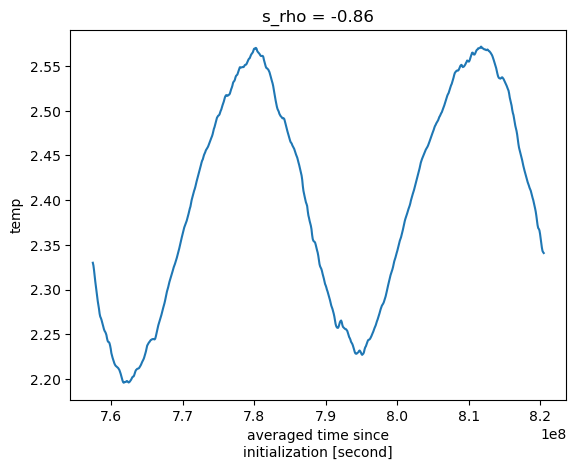

In [16]:
data.plot()

In [22]:
import ujson
jsonfile='test.json.zstd'
storage_options= {"compression": "zstd"}
#with open(jsonfile, mode='w') as f :
#    json.dump(out, f)
    
with fsspec.open(jsonfile, mode="wt", **(storage_options or {})) as f:
    ujson.dump(out, f)

In [28]:
%%time
import xarray as xr
test= xr.open_dataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo":'file:///home1/datawork/todaka/git/auto-kerchunk/notebooks/test.json.zstd',
            "target_options": {
                "compression": "zstd"
            },
        },
        "consolidated": False
    },chunks={'time':1, 'eta_rho': 'auto' , 'eta_rho': 'auto', 'xi_rho': 'auto'}
)
test

CPU times: user 2.22 s, sys: 212 ms, total: 2.43 s
Wall time: 2.42 s


<xarray.Dataset>
Dimensions:     (time: 731, s_w: 76, eta_rho: 677, xi_rho: 1259, s_rho: 75,
                 auxil: 4, eta_v: 676, xi_u: 1258)
Coordinates: (12/14)
  * auxil       (auxil) float32 nan nan nan nan
  * eta_rho     (eta_rho) float32 1.0 2.0 3.0 4.0 ... 674.0 675.0 676.0 677.0
  * eta_v       (eta_v) float32 1.5 2.5 3.5 4.5 5.5 ... 673.5 674.5 675.5 676.5
    lat_rho     (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 677, 1259), meta=np.ndarray>
    lat_u       (time, eta_rho, xi_u) float32 dask.array<chunksize=(1, 677, 1258), meta=np.ndarray>
    lat_v       (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 676, 1259), meta=np.ndarray>
    ...          ...
    lon_v       (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 676, 1259), meta=np.ndarray>
  * s_rho       (s_rho) float32 -0.9933 -0.98 -0.9667 ... -0.02 -0.006667
  * s_w         (s_w) float32 -1.0 -0.9867 -0.9733 ... -0.02667 -0.01333 0.0
  * time        (time) float64 7.574e+08 7.575e+08 ... 8.204e+08 8.205e+08
  * xi_rho      (xi_rho) float32 1.0 2.0 3.0 ... 1.257e+03 1.258e+03 1.259e+03
  * xi_u        (xi_u) float32 1.5 2.5 3.5 4.5 ... 1.256e+03 1.258e+03 1.258e+03
Data variables: (12/39)
    AKt         (time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 16, 170, 315), meta=np.ndarray>
    Cs_r        (time, s_rho) float32 dask.array<chunksize=(1, 75), meta=np.ndarray>
    Cs_w        (time, s_w) float32 dask.array<chunksize=(1, 76), meta=np.ndarray>
    Vtransform  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    angle       (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 677, 1259), meta=np.ndarray>
    bostr       (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 677, 1259), meta=np.ndarray>
    ...          ...
    v           (time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 15, 169, 315), meta=np.ndarray>
    vbar        (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 676, 1259), meta=np.ndarray>
    w           (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 15, 170, 315), meta=np.ndarray>
    wstr        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 677, 1259), meta=np.ndarray>
    xl          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 677, 1259), meta=np.ndarray>
Attributes: (12/54)
    CPP-options:    REGIONAL ARVOR_exp1_Ofrc MPI OBC_NORTH OBC_SOUTH LOGFILE ...
    Cdb_expl:       Range of quadratic drag coefficient
    Cdb_max:        0.10000000149011612
    Cdb_min:        9.999999747378752e-05
    Cs_r:           [-0.989244818687439, -0.9666978716850281, -0.942861378192...
    Cs_r_expl:      S-coordinate stretching curves at RHO-points
    ...             ...
    theta_s_expl:   S-coordinate surface control parameter
    title:          ARVOR_V2_exp1_Ofrc
    tnu4:           0.0
    tnu4_expl:      biharmonic mixing coefficient for tracers
    type:           CROCO averages file
    units:          meter4 second-1

In [31]:
%%time
data=test.temp.isel(s_rho=10).mean(dim='eta_rho').mean(dim='xi_rho').compute()

CPU times: user 36.4 s, sys: 1.97 s, total: 38.3 s
Wall time: 1min 11s


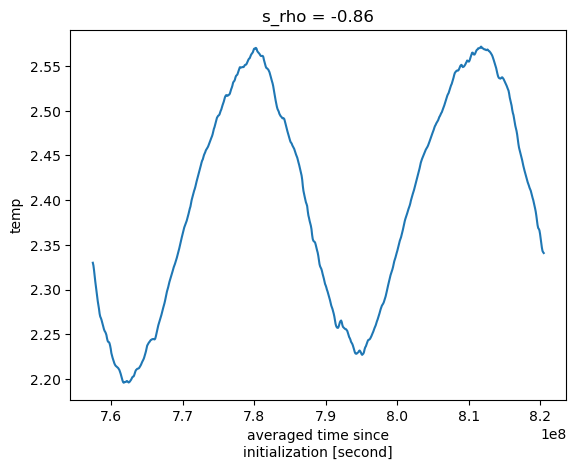

In [16]:
data.plot()